# Example 3: Simple model PyMC

This notebook is a series of independent cells showing how to create a simple model from the beginning to the end using GeMpy

### Importing dependencies

In [2]:
# Importing
import theano.tensor as T
import sys, os
sys.path.append("../GeMpy")

# Importing GeMpy modules
import GeMpy

# Reloading (only for development purposes)
import importlib
importlib.reload(GeMpy)

# Usuful packages
import numpy as np
import pandas as pn

import matplotlib.pyplot as plt

# This was to choose the gpu
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Default options of printin
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)

%matplotlib inline
#%matplotlib notebook

## Visualize data

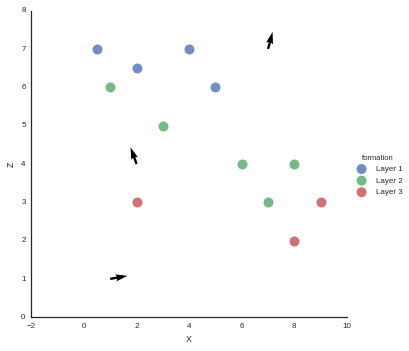

In [35]:
# Setting the extent
geo_data = GeMpy.import_data([0,10,0,10,0,10])


# =========================
# DATA GENERATION IN PYTHON
# =========================
# Layers coordinates
layer_1 = np.array([[0.5,4,7], [2,4,6.5], [4,4,7], [5,4,6]])#-np.array([5,5,4]))/8+0.5
layer_2 = np.array([[3,4,5], [6,4,4],[8,4,4], [7,4,3], [1,4,6]])
layers = np.asarray([layer_1,layer_2])

# Foliations coordinates
dip_pos_1 = np.array([7,4,7])#- np.array([5,5,4]))/8+0.5
dip_pos_2 = np.array([2.,4,4])

# Dips
dip_angle_1 = float(15)
dip_angle_2 = float(340)
dips_angles = np.asarray([dip_angle_1, dip_angle_2], dtype="float64")

# Azimuths
azimuths = np.asarray([90,90], dtype="float64")

# Polarity
polarity = np.asarray([1,1], dtype="float64")

# Setting foliations and interfaces values
GeMpy.set_interfaces(geo_data, pn.DataFrame(
    data = {"X" :np.append(layer_1[:, 0],layer_2[:,0]),
            "Y" :np.append(layer_1[:, 1],layer_2[:,1]),
            "Z" :np.append(layer_1[:, 2],layer_2[:,2]),
            "formation" : np.append(
               np.tile("Layer 1", len(layer_1)), 
               np.tile("Layer 2", len(layer_2))),
            "labels" : [r'${\bf{x}}_{\alpha \, 0}^1$',
               r'${\bf{x}}_{\alpha \, 1}^1$',
               r'${\bf{x}}_{\alpha \, 2}^1$',
               r'${\bf{x}}_{\alpha \, 3}^1$',
               r'${\bf{x}}_{\alpha \, 0}^2$',
               r'${\bf{x}}_{\alpha \, 1}^2$',
               r'${\bf{x}}_{\alpha \, 2}^2$',
               r'${\bf{x}}_{\alpha \, 3}^2$',
               r'${\bf{x}}_{\alpha \, 4}^2$'] }))

GeMpy.set_foliations(geo_data,  pn.DataFrame(
    data = {"X" :np.append(dip_pos_1[0],dip_pos_2[0]),
            "Y" :np.append(dip_pos_1[ 1],dip_pos_2[1]),
            "Z" :np.append(dip_pos_1[ 2],dip_pos_2[2]),
            "azimuth" : azimuths,
            "dip" : dips_angles,
            "polarity" : polarity,
            "formation" : ["Layer 1", "Layer 2"],
            "labels" : [r'${\bf{x}}_{\beta \,{0}}$',
              r'${\bf{x}}_{\beta \,{1}}$'] })) 



layer_3 = np.array([[2,4,3], [8,4,2], [9,4,3]])
dip_pos_3 = np.array([1,4,1])
dip_angle_3 = float(80)
azimuth_3 = 90
polarity_3 = 1



GeMpy.set_interfaces(geo_data, pn.DataFrame(
    data = {"X" :layer_3[:, 0],
            "Y" :layer_3[:, 1],
            "Z" :layer_3[:, 2],
            "formation" : np.tile("Layer 3", len(layer_3)), 
            "labels" : [  r'${\bf{x}}_{\alpha \, 0}^3$',
                           r'${\bf{x}}_{\alpha \, 1}^3$',
                           r'${\bf{x}}_{\alpha \, 2}^3$'] }), append = True)
GeMpy.get_raw_data(geo_data,"interfaces")

 
GeMpy.set_foliations(geo_data, pn.DataFrame(data = {
                     "X" : dip_pos_3[0],
                     "Y" : dip_pos_3[1],
                     "Z" : dip_pos_3[2],
                     "azimuth" : azimuth_3,
                     "dip" : dip_angle_3,
                     "polarity" : polarity_3,
                     "formation" : [ 'Layer 3'],
                     "labels" : r'${\bf{x}}_{\beta \,{2}}$'}), append = True)


GeMpy.set_data_series(geo_data, {'younger': ('Layer 1', 'Layer 2'),
                      'older': 'Layer 3'}, order_series = ['younger', 'older'])

GeMpy.plot_data(geo_data)

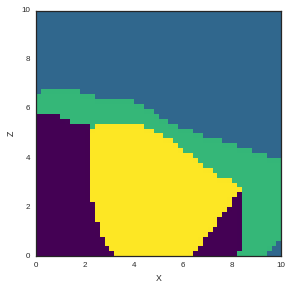

In [36]:
GeMpy.set_interpolator(geo_data, u_grade = 0)
GeMpy.compute_block_model(geo_data, series_number= 'all', verbose = 0)
GeMpy.plot_section(geo_data, 13)


In [51]:
import pymc as pm

inter = geo_data.interpolator._data.interfaces

Z_unc = pm.Normal('Z_unc', inter['Z'], 1./np.square(1))

@pm.deterministic
def model(value=0, Z_unc = Z_unc):
    geo_data.interpolator._data.interfaces['Z'] = pn.DataFrame(Z_unc)
    GeMpy.compute_block_model(geo_data, u_grade = 0)
   # print(geo_data.interpolator._data.interfaces)
    return geo_data.interpolator.block.get_value()

pymc_model = pm.Model([Z_unc, model])

In [52]:
M = pm.MCMC(pymc_model)

In [53]:
M.sample(4)

 [---------------------125%----------------------] 5 of 4 complete in 5.8 sec

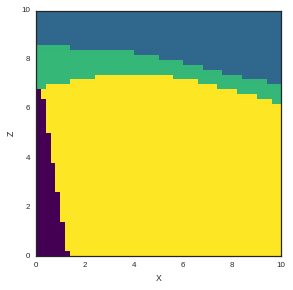

In [54]:
GeMpy.plot_section(geo_data, 13, block = M.trace('model')()[2])